Importing Packages

In [396]:
import requests
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf as acf #Autocorrelation Functions
from statsmodels.tsa.stattools import adfuller #Augmented Dickey-Fuller test for stationary testing
from statsmodels.tsa.seasonal import seasonal_decompose #Seasonal Decomposition Function

Importing CSV FX Data

In [397]:
filepath = r"C:\Users\ariff_n\Downloads\VND=X.csv"
fxdata = pd.read_csv(filepath)

# Remove rows containing NaN values
fxdata = fxdata.dropna(axis=0)

# Retaining only Date and Close columns
fxdata = fxdata[['Date', 'Close']]

# Convert 'Date' column to datetime format
fxdata['Date'] = pd.to_datetime(fxdata['Date'])

# Set 'Date' column as the index
fxdata.set_index('Date', inplace=True)

# Group data by year and select the final data point of each year
fxdata = fxdata.groupby(fxdata.index.year).apply(lambda x: x.resample('Y').last())

# Reset index to just the year
fxdata.index = fxdata.index.droplevel(1)

# Print FX Dataset
print(fxdata)

        Close
Date         
2003  15002.0
2004  15302.0
2005  15913.0
2006  16035.0
2007  15870.0
2008  17204.0
2009  18400.0
2010  19460.0
2011  20995.0
2012  20515.0
2013  21055.0
2014  21062.0
2015  22185.0
2016  22468.0
2017  22343.0
2018  23194.0
2019  23171.0
2020  23088.0
2021  22765.0
2022  23600.0
2023  24235.0
2024  24740.0


Fetching IMF Data

In [398]:
def imf_data(endpoint):
    url = f"https://www.imf.org/external/datamapper/api/v1/{endpoint}/VNM"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        values = data['values'][endpoint]['VNM']
        df = pd.DataFrame(list(values.items()), columns=['Year', endpoint.replace('/', ' ')])
        df['Year'] = pd.to_numeric(df['Year'])
        df = df[(df['Year'] >= 2003) & (df['Year'] <= 2024)]
        df.set_index('Year', inplace=True)
        return df

# Define endpoints for each indicator
endpoints = {'NGDPDPC': 'GDP per Capita (Current Prices)',
             'BCA': 'Current Account Balance',
             'PCPIPCH': 'Average CPI'}

# Fetch data for each endpoint and concatenate DataFrames
dfs = {title: imf_data(endpoint) for endpoint, title in endpoints.items()}
imfdata = pd.concat(dfs.values(), axis=1)

# Rename columns
imfdata.columns = endpoints.values()

# Print the combined DataFrame
print(imfdata)

      GDP per Capita (Current Prices)  Current Account Balance  Average CPI
Year                                                                       
2003                          610.357                   -1.931          3.3
2004                          756.981                   -1.591          7.9
2005                          873.136                   -0.560          8.4
2006                          996.255                   -0.164          7.5
2007                         1152.267                   -6.992          8.3
2008                         1446.562                  -10.787         23.1
2009                         1481.442                   -6.608          6.7
2010                         1628.013                   -4.276          9.2
2011                         1949.826                    0.233         18.7
2012                         2197.619                    9.267          9.1
2013                         2369.973                    7.744          6.6
2014        

IMF Data against Year

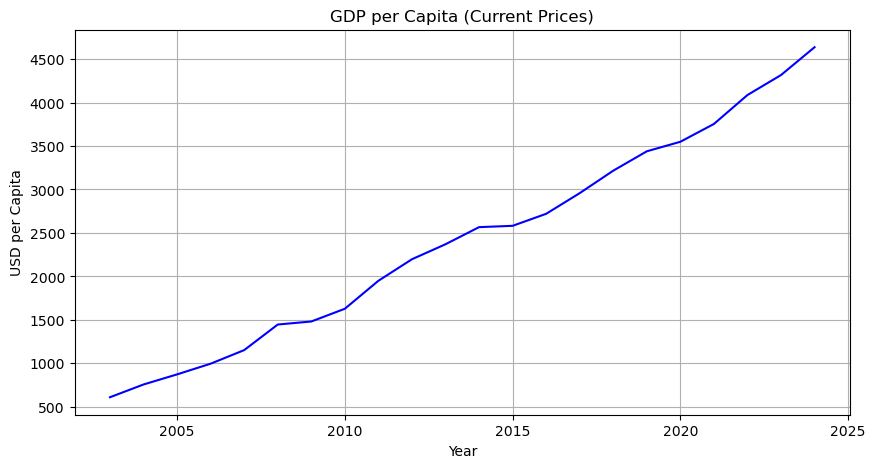

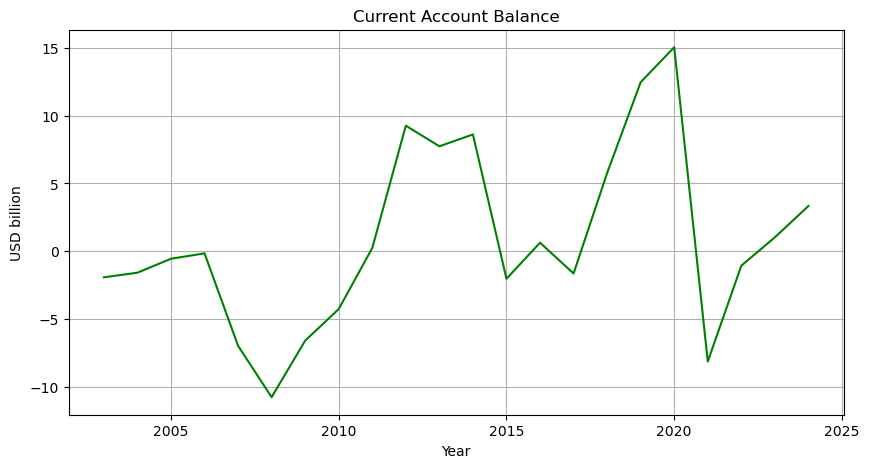

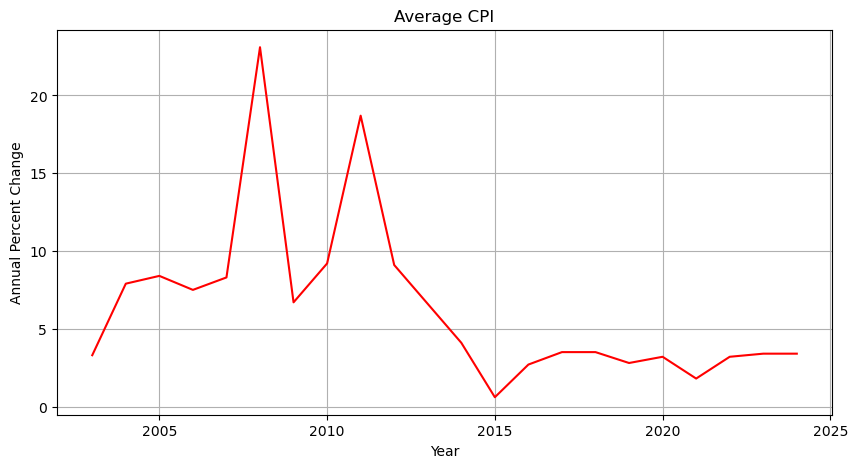

In [399]:
def imf_plot(imfdata, variable_name, color, ylabel):
    plt.figure(figsize=(10, 5))
    plt.plot(imfdata.index, imfdata[variable_name], color=color)  # Corrected from 'data' to 'imfdata'
    plt.title(variable_name)
    plt.xlabel('Year')
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

# Plotting each variable
imf_plot(imfdata, 'GDP per Capita (Current Prices)', 'blue', 'USD per Capita' )  # GDP per Capita
imf_plot(imfdata, 'Current Account Balance', 'green', 'USD billion')     # Current Account Balance
imf_plot(imfdata, 'Average CPI', 'red', 'Annual Percent Change')   # Consumer Price Index (CPI)

Scatterplots of IV against DV

      GDP per Capita (Current Prices)  Current Account Balance  Average CPI  \
2003                          610.357                   -1.931          3.3   
2004                          756.981                   -1.591          7.9   
2005                          873.136                   -0.560          8.4   
2006                          996.255                   -0.164          7.5   
2007                         1152.267                   -6.992          8.3   
2008                         1446.562                  -10.787         23.1   
2009                         1481.442                   -6.608          6.7   
2010                         1628.013                   -4.276          9.2   
2011                         1949.826                    0.233         18.7   
2012                         2197.619                    9.267          9.1   
2013                         2369.973                    7.744          6.6   
2014                         2566.854               

C:\Users\ariff_n\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
C:\Users\ariff_n\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
C:\Users\ariff_n\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
C:\Users\ariff_n\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


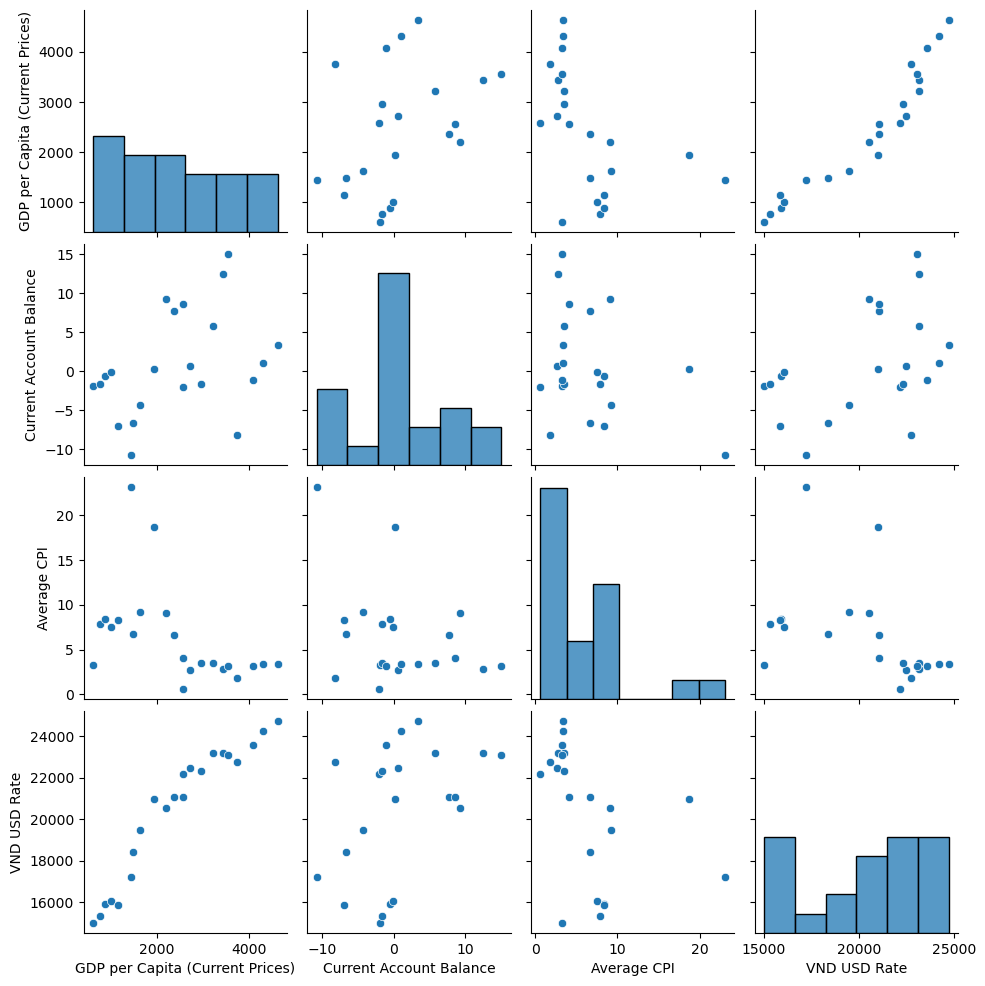

In [400]:
scatterplot = pd.DataFrame({
    'GDP per Capita (Current Prices)': imfdata['GDP per Capita (Current Prices)'],
    'Current Account Balance': imfdata['Current Account Balance'],
    'Average CPI': imfdata['Average CPI'],
    'VND USD Rate': fxdata['Close']
})
print(scatterplot)
sns.pairplot(scatterplot)

ACF Stationarity Check

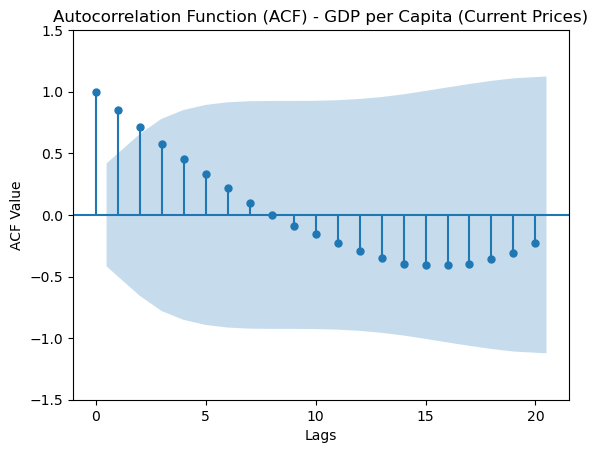

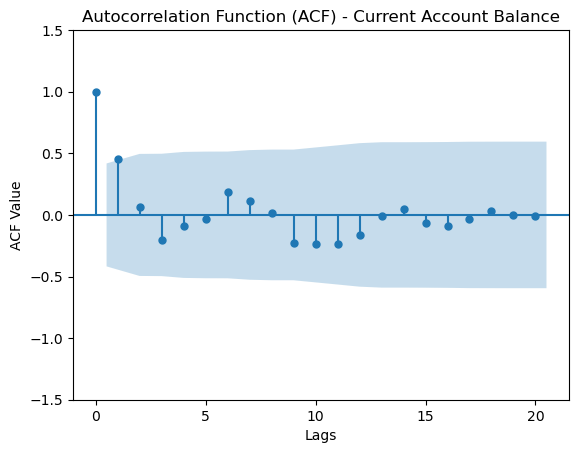

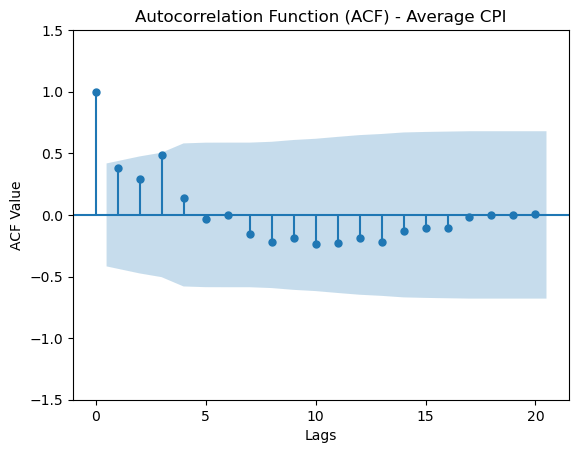

In [401]:
def acf_plot(imfdata, variable_name):
    acf(imfdata[variable_name], lags=20)
    plt.title("Autocorrelation Function (ACF) - " + variable_name)
    plt.xlabel("Lags")
    plt.ylabel("ACF Value")
    plt.ylim(-1.5, 1.5)
    plt.show()

# Plotting each variable
acf_plot(imfdata, 'GDP per Capita (Current Prices)')
acf_plot(imfdata, 'Current Account Balance')
acf_plot(imfdata, 'Average CPI')

ADF Test

In [402]:
def adf_check(imfdata, variable_name):
    adftest = adfuller(imfdata[variable_name], autolag='AIC', regression='ct')
    print("ADF Test Result - "+variable_name)
    print("Null Hypothesis: The series has a unit root (non-stationary)")
    print("ADF-Statistic:", adftest[0])
    print("P-Value:", adftest[1])
    print("Number of lags:", adftest[2])
    print("Number of observations:", adftest[3])
    print("Critical Values:", adftest[4])
    if adftest[1] <= 0.1:
        print("\033[1mThe series is stationary (P-Value <= 0.1)\033[0m")
        print("\n")
        return 0
    else:
        print("\033[1mThe series is not stationary (P-Value > 0.1)\033[0m")
        print("\n")
        return 1
    
# DataFrame to store the results
adf_results = pd.DataFrame(columns=['Variable', 'Stationarity Treatment Required'])

# Iterate over each variable
for variable_name in imfdata.columns:
    result = adf_check(imfdata, variable_name)
    # Add the results to the DataFrame
    adf_results.loc[len(adf_results)] = [variable_name, result]

print("\033[1m\nSummary of ADF Test:\033[0m")
print(adf_results)

ADF Test Result - GDP per Capita (Current Prices)
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -1.6739253057138763
P-Value: 0.7621639969276106
Number of lags: 1
Number of observations: 20
Critical Values: {'1%': -4.499264375, '5%': -3.65827175, '10%': -3.26894}
The series is not stationary (P-Value > 0.1)


ADF Test Result - Current Account Balance
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -3.263115163411973
P-Value: 0.07254275841102513
Number of lags: 2
Number of observations: 19
Critical Values: {'1%': -4.533555843417408, '5%': -3.673209405161102, '10%': -3.277269653010643}
The series is stationary (P-Value <= 0.1)


ADF Test Result - Average CPI
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -2.825724021385674
P-Value: 0.18765679466094448
Number of lags: 6
Number of observations: 15
Critical Values: {'1%': -4.7284062962962965, '5%': -3.7567874814814814, '10%': -3.323498888888889}
The series

Stationarity Treatment via Logarithmic Conversion

In [403]:
imfdata2 = imfdata
if (adf_results['Stationarity Treatment Required'] == 1).any():
    # Apply logarithmic transformation, first differences, and convert to growth rates
    for variable_name in imfdata2.columns:
        if adf_results.loc[adf_results['Variable'] == variable_name, 'Stationarity Treatment Required'].values[0] == 1:
            treatment_data = imfdata2[variable_name]
            treatment_data = np.log(treatment_data)
            imfdata2[variable_name] = treatment_data
            imfdata2 = imfdata2.rename(columns={variable_name:'Log '+variable_name})

# Reset adf_results to an empty DataFrame
adf_results = pd.DataFrame(columns=['Variable', 'Stationarity Treatment Required'])

# Display the transformed dataset
print("\033[1m\nTransformed Dataset:\033[0m")
print(imfdata2)


Transformed Dataset:
      Log GDP per Capita (Current Prices)  Current Account Balance  \
Year                                                                 
2003                             6.414044                   -1.931   
2004                             6.629338                   -1.591   
2005                             6.772091                   -0.560   
2006                             6.904003                   -0.164   
2007                             7.049487                   -6.992   
2008                             7.276945                  -10.787   
2009                             7.300771                   -6.608   
2010                             7.395116                   -4.276   
2011                             7.575495                    0.233   
2012                             7.695130                    9.267   
2013                             7.770634                    7.744   
2014                             7.850436                    8.617  

In [404]:
# Iterate over each variable
for variable_name in imfdata2.columns:
    result = adf_check(imfdata2, variable_name)
    # Add the results to the DataFrame
    adf_results.loc[len(adf_results)] = [variable_name, result]

print("\033[1m\nSummary of ADF Test:\033[0m")
print(adf_results)

ADF Test Result - Log GDP per Capita (Current Prices)
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -2.5129900739741786
P-Value: 0.3214984534332238
Number of lags: 8
Number of observations: 13
Critical Values: {'1%': -4.8844381383705056, '5%': -3.8223332407828856, '10%': -3.3593537778789258}
The series is not stationary (P-Value > 0.1)


ADF Test Result - Current Account Balance
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -3.263115163411973
P-Value: 0.07254275841102513
Number of lags: 2
Number of observations: 19
Critical Values: {'1%': -4.533555843417408, '5%': -3.673209405161102, '10%': -3.277269653010643}
The series is stationary (P-Value <= 0.1)


ADF Test Result - Log Average CPI
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -1.4125388776051204
P-Value: 0.8571939051936543
Number of lags: 8
Number of observations: 13
Critical Values: {'1%': -4.8844381383705056, '5%': -3.8223332407828856, '10

Stationarity Treatment via Differences

In [405]:
imfdata3 = imfdata2
if (adf_results['Stationarity Treatment Required'] == 1).any():
    # Apply first differences, and convert to growth rates
    for variable_name in imfdata3.columns:
        if adf_results.loc[adf_results['Variable'] == variable_name, 'Stationarity Treatment Required'].values[0] == 1:
            treatment_data = imfdata3[variable_name]
            treatment_data_diff = treatment_data.diff()
            treatment_data_growth = treatment_data_diff*100 
            imfdata3[variable_name] = treatment_data_growth
            new_column_name = variable_name.replace('Log ', '') + ' Growth'
            imfdata3.rename(columns={variable_name: new_column_name}, inplace=True)

# Removing first row
imfdata3.drop(imfdata.index[0], inplace=True)

# Display the transformed dataset
print("\033[1m\nTransformed Dataset:\033[0m")
print(imfdata3)



Transformed Dataset:
      GDP per Capita (Current Prices) Growth  Current Account Balance  \
Year                                                                    
2004                               21.529412                   -1.591   
2005                               14.275317                   -0.560   
2006                               13.191192                   -0.164   
2007                               14.548334                   -6.992   
2008                               22.745840                  -10.787   
2009                                2.382623                   -6.608   
2010                                9.434432                   -4.276   
2011                               18.037989                    0.233   
2012                               11.963436                    9.267   
2013                                7.550406                    7.744   
2014                                7.980246                    8.617   
2015                         

In [406]:
# Iterate over each variable
# Reset adf_results to an empty DataFrame
adf_results = pd.DataFrame(columns=['Variable', 'Stationarity Treatment Required'])

for variable_name in imfdata3.columns:
    result = adf_check(imfdata3, variable_name)
    # Add the results to the DataFrame
    adf_results.loc[len(adf_results)] = [variable_name, result]

print("\033[1m\nSummary of ADF Test:\033[0m")
print(adf_results)

ADF Test Result - GDP per Capita (Current Prices) Growth
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -4.530472654430753
P-Value: 0.001345266403424076
Number of lags: 0
Number of observations: 20
Critical Values: {'1%': -4.499264375, '5%': -3.65827175, '10%': -3.26894}
The series is stationary (P-Value <= 0.1)


ADF Test Result - Current Account Balance
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -3.219257568454067
P-Value: 0.08063223828508315
Number of lags: 2
Number of observations: 18
Critical Values: {'1%': -4.572463998628258, '5%': -3.6900701783264744, '10%': -3.2866460905349797}
The series is stationary (P-Value <= 0.1)


ADF Test Result - Average CPI Growth
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -1.1826540796610752
P-Value: 0.9139970953006162
Number of lags: 6
Number of observations: 14
Critical Values: {'1%': -4.7993511224489795, '5%': -3.7867277551020404, '10%': -3.3399172011661

Final Dataset (for Trial Purposes)

In [407]:
# Assuming the first two columns of imfdata3 are named 'Column1' and 'Column2',
# and the third column of imfdata is named 'Column3'
final_data = pd.DataFrame({
    'GDP per Capita (Current Prices) Growth': imfdata3['GDP per Capita (Current Prices) Growth'],
    'Current Account Balance': imfdata3['Current Account Balance'],
    'Average CPI': imfdata['Average CPI'],
    'VND USD Rate': fxdata['Close']
})
final_data = final_data.drop(final_data.index[0])

print(final_data)


      GDP per Capita (Current Prices) Growth  Current Account Balance  \
2004                               21.529412                   -1.591   
2005                               14.275317                   -0.560   
2006                               13.191192                   -0.164   
2007                               14.548334                   -6.992   
2008                               22.745840                  -10.787   
2009                                2.382623                   -6.608   
2010                                9.434432                   -4.276   
2011                               18.037989                    0.233   
2012                               11.963436                    9.267   
2013                                7.550406                    7.744   
2014                                7.980246                    8.617   
2015                                0.584725                   -2.039   
2016                                5.216537       

Correlation Data

                                        GDP per Capita (Current Prices) Growth  \
GDP per Capita (Current Prices) Growth                                1.000000   
Current Account Balance                                              -0.319234   
Average CPI                                                           0.800179   
VND USD Rate                                                         -0.668155   

                                        Current Account Balance  Average CPI  \
GDP per Capita (Current Prices) Growth                -0.319234     0.800179   
Current Account Balance                                1.000000    -0.364469   
Average CPI                                           -0.364469     1.000000   
VND USD Rate                                           0.441450    -0.534023   

                                        VND USD Rate  
GDP per Capita (Current Prices) Growth     -0.668155  
Current Account Balance                     0.441450  
Average CPI            

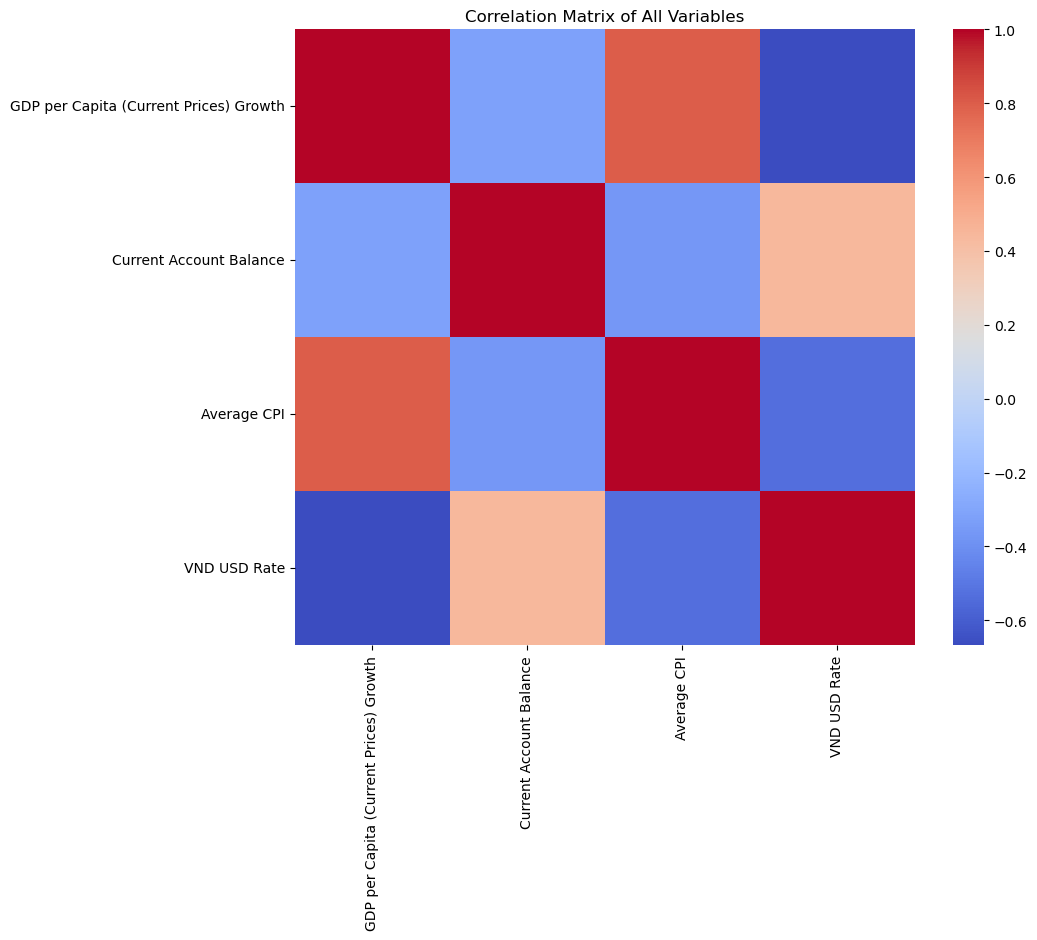

In [408]:
# Calculating correlation coefficients
correlation_matrix = final_data.corr()
print(correlation_matrix)

# Plotting correlations using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title("Correlation Matrix of All Variables")
plt.show()


C:\Users\ariff_n\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
C:\Users\ariff_n\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
C:\Users\ariff_n\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
C:\Users\ariff_n\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


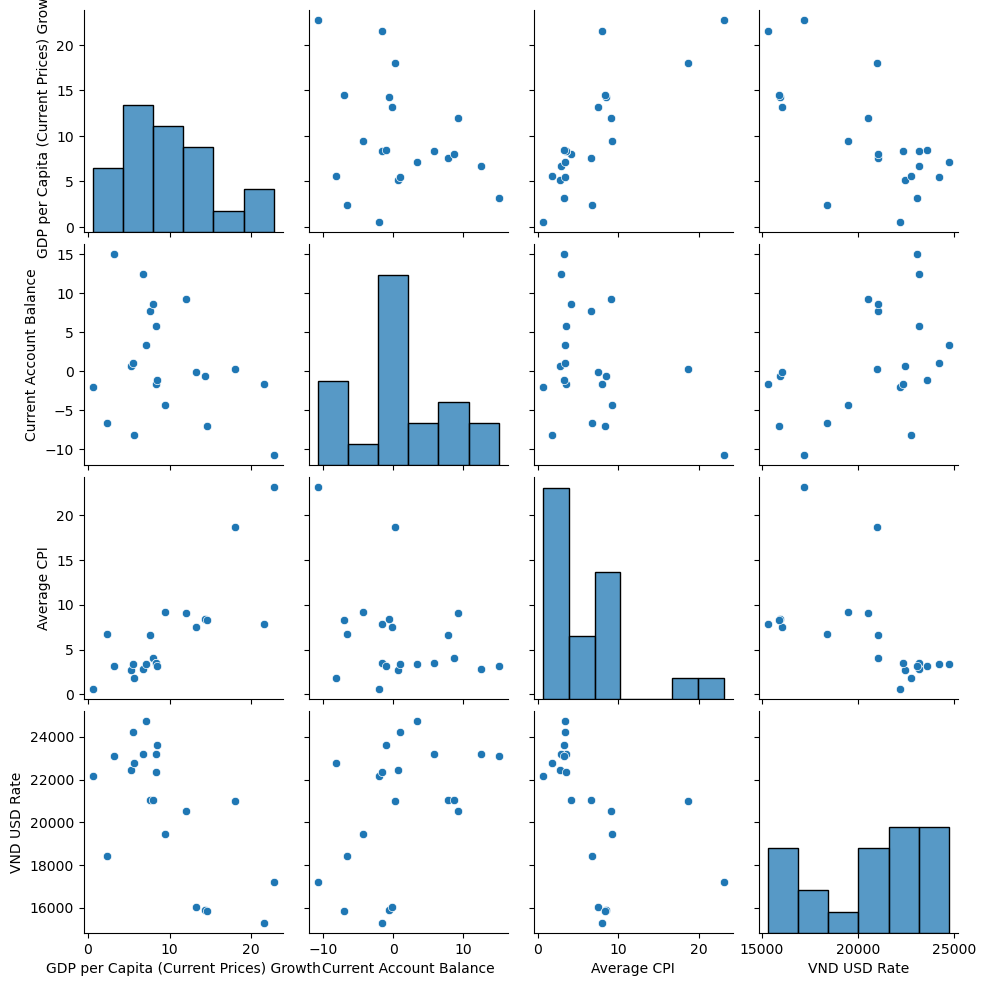

In [409]:
sns.pairplot(final_data)
plt.show()

Multivariate Linear Regression

In [ ]:
#%%
# Function to calculate R-squared value
def calculate_r_squared(y_true, y_pred):
    y_mean = np.mean(y_true)
    ss_total = np.sum((y_true - y_mean)**2)
    ss_residual = np.sum((y_true - y_pred)**2)
    r_squared = 1 - (ss_residual / ss_total)
    return r_squared

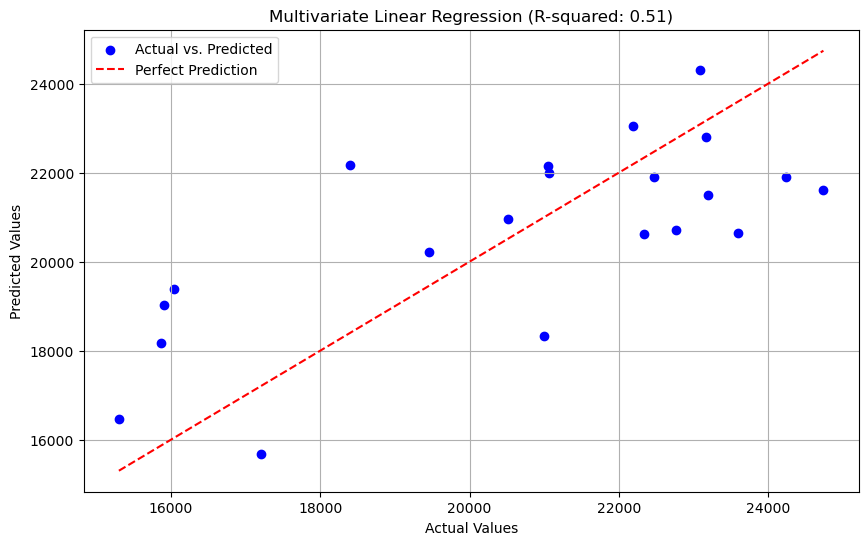

In [422]:
# Splitting the data into features (X) and target variable (y)
X = final_data[['GDP per Capita (Current Prices) Growth','Current Account Balance','Average CPI']]
y = final_data['VND USD Rate'].values.flatten()  # Flattening y to ensure it's a 1D array

model = LinearRegression()
model.fit(X, y)

# Predicting FX rate
y_pred = model.predict(X)

# Calculate R-squared
r_squared = model.score(X, y)

# Plotting the multivariate regression with legends, variable annotations, and R-squared value
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, color='blue', label='Actual vs. Predicted')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', label='Perfect Prediction')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Multivariate Linear Regression (R-squared: {:.2f})'.format(r_squared))
plt.legend()
plt.grid(True)
plt.show()

In [420]:
# Printing the coefficients and intercept
print("\033[1mCoefficients:\033[0m")
for var, coef in zip(X.columns, model.coef_):
    print(f"{var}: {coef}")
print("\n")
print("\033[1mIntercept:\033[0m", model.intercept_)
print("\033[1mR-squared Value:\033[0m", r_squared)

Coefficients:
GDP per Capita (Current Prices) Growth: -332.0368225818276
Current Account Balance: 117.21789408435787
Average CPI: 45.34226355693198


Intercept: 23443.210991600703
R-squared Value: 0.5067053879607123


Stationarity Treatment via Seasonal Decomposition


Transformed Dataset:
2004-12-31     7.9
2005-12-31     8.4
2006-12-31     7.5
2007-12-31     8.3
2008-12-31    23.1
2009-12-31     6.7
2010-12-31     9.2
2011-12-31    18.7
2012-12-31     9.1
2013-12-31     6.6
2014-12-31     4.1
2015-12-31     0.6
2016-12-31     2.7
2017-12-31     3.5
2018-12-31     3.5
2019-12-31     2.8
2020-12-31     3.2
2021-12-31     1.8
2022-12-31     3.2
2023-12-31     3.4
2024-12-31     3.4
Freq: A-DEC, Name: Average CPI, dtype: float64
      GDP per Capita (Current Prices) Growth  Current Account Balance  \
Year                                                                    
2004                               21.529412                   -1.591   
2005                               14.275317                   -0.560   
2006                               13.191192                   -0.164   
2007                               14.548334                   -6.992   
2008                               22.745840                  -10.787   
2009                 

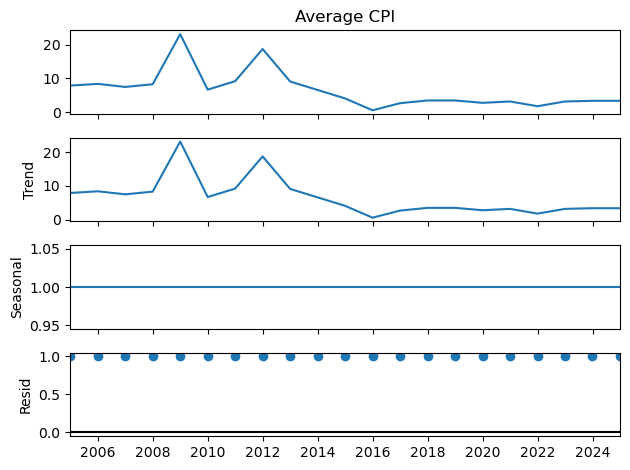

In [410]:
imfdata4 = imfdata3
reference = imfdata
reference.index = pd.to_datetime(reference.index, format='%Y', errors='coerce')

if (adf_results['Stationarity Treatment Required'] == 1).any():
    for variable_name in imfdata3.columns:
        if adf_results.loc[adf_results['Variable'] == variable_name, 'Stationarity Treatment Required'].values[0] == 1:
            original_name = variable_name.replace(' Growth', '')
            treatment_data=reference[original_name].drop(reference.index[0])
            treatment_data.index = pd.date_range(start=treatment_data.index[0], periods=len(treatment_data), freq='A')
            ssndecomp = seasonal_decompose(treatment_data, model='multiplicative')
            residual = ssndecomp.resid
            imfdata4[variable_name] = residual
            imfdata4.rename(columns={variable_name: 'Residual Seasonal Decomposition of '+original_name}, inplace=True)

# Display the transformed dataset
print("\033[1m\nTransformed Dataset:\033[0m")
ssndecomp.plot()
print(treatment_data)
print(imfdata4)

ADF Test after Treatment

In [411]:
print("\033[1m\nSummary of ADF Test:\033[0m")
print("\n")
for variable_name in imfdata.columns:
    result = adf_check(imfdata, variable_name)


Summary of ADF Test:


ADF Test Result - GDP per Capita (Current Prices)
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -2.5129900739741786
P-Value: 0.3214984534332238
Number of lags: 8
Number of observations: 13
Critical Values: {'1%': -4.8844381383705056, '5%': -3.8223332407828856, '10%': -3.3593537778789258}
The series is not stationary (P-Value > 0.1)


ADF Test Result - Current Account Balance
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -3.263115163411973
P-Value: 0.07254275841102513
Number of lags: 2
Number of observations: 19
Critical Values: {'1%': -4.533555843417408, '5%': -3.673209405161102, '10%': -3.277269653010643}
The series is stationary (P-Value <= 0.1)


ADF Test Result - Average CPI
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -2.825724021385674
P-Value: 0.18765679466094448
Number of lags: 6
Number of observations: 15
Critical Values: {'1%': -4.7284062962962965, '5%': -3.75678